In [1]:
import numpy as np
import tensorflow as tf
import time

import mnist

tf.logging.set_verbosity(tf.logging.INFO)


class VariationalAutoEncoder(object):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self._initialize_network(**self.network_architecture)
        self.x = tf.placeholder(tf.float32, shape=[None, self.image_width * self.image_width], name="input")

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.writer = tf.summary.FileWriter(".", self.sess.graph)
        self.sess.run(init)

    def _create_network(self):
        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent space
        self._recognition_network()

        # Draw one sample z from Gaussian distribution
        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1, dtype=tf.float32)
        # z = mu + sigma * epsilon
        self.z = tf.add(self.z_mean, tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self._generator_network()

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 1)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus
            )
        self.z_mean = tf.layers.dense(
            inputs=self.input_layers[-1],
            units=self.n_z,
            activation=None,
            name="z_mean"
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.input_layers[-1],
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq"
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = self.z
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid)

    def _create_loss_optimizer(self):
        with tf.name_scope("cost"):
            # The loss is composed of two terms:
            # 1.) The reconstruction loss (the negative log probability
            #     of the input under the reconstructed Bernoulli distribution
            #     induced by the decoder in the data space).
            #     This can be interpreted as the number of "nats" required
            #     for reconstructing the input when the activation in latent
            #     is given.
            # Adding 1e-10 to avoid evaluation of log(0.0)
            reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                               + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)

            # 2.) The latent loss, which is defined as the KL divergence
            #     between the distribution in latent space induced by the encoder on
            #     the data and some prior. This acts as a kind of regularizer.
            #     This can be interpreted as the number of "nats" required
            #     for transmitting the the latent space distribution given
            #     the prior.
            latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean)
                                               - tf.exp(self.z_log_sigma_sq), 1)

            self.cost = tf.reduce_mean(reconstr_loss + latent_loss, name="total_cost")  # average over batch
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = VariationalAutoEncoder(network_architecture,
                                 learning_rate=learning_rate,
                                 batch_size=batch_size)
    # Training cycle
    _, train_y = mnist.train()
    train_x = mnist.train_32()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            # print(i)
            batch_xs = np.asarray(train_x[i:i + batch_size], dtype=np.float32) / 256
            batch_xs = batch_xs.reshape((-1, w * w))

            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
    return vae


network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train(network_architecture, training_epochs=30)

Epoch: 0001 Cost: 225.238363520 Time: 5.928
Epoch: 0002 Cost: 174.737272746 Time: 11.762
Epoch: 0003 Cost: 162.517568385 Time: 17.566
Epoch: 0004 Cost: 156.732689311 Time: 23.380
Epoch: 0005 Cost: 153.104451040 Time: 29.195
Epoch: 0006 Cost: 150.276736908 Time: 35.014
Epoch: 0007 Cost: 147.801316121 Time: 40.837
Epoch: 0008 Cost: 146.065535329 Time: 46.636
Epoch: 0009 Cost: 144.751965714 Time: 52.464
Epoch: 0010 Cost: 143.681122309 Time: 58.298
Epoch: 0011 Cost: 142.889396744 Time: 64.098
Epoch: 0012 Cost: 142.103902944 Time: 69.921
Epoch: 0013 Cost: 141.402996724 Time: 75.742
Epoch: 0014 Cost: 140.895841726 Time: 81.596
Epoch: 0015 Cost: 140.415854060 Time: 87.579
Epoch: 0016 Cost: 139.937343343 Time: 93.570
Epoch: 0017 Cost: 139.520417811 Time: 99.462
Epoch: 0018 Cost: 139.078258514 Time: 105.362
Epoch: 0019 Cost: 138.756232885 Time: 111.303
Epoch: 0020 Cost: 138.384765828 Time: 117.197
Epoch: 0021 Cost: 138.026989009 Time: 123.165
Epoch: 0022 Cost: 137.711990344 Time: 129.062
Epoch:

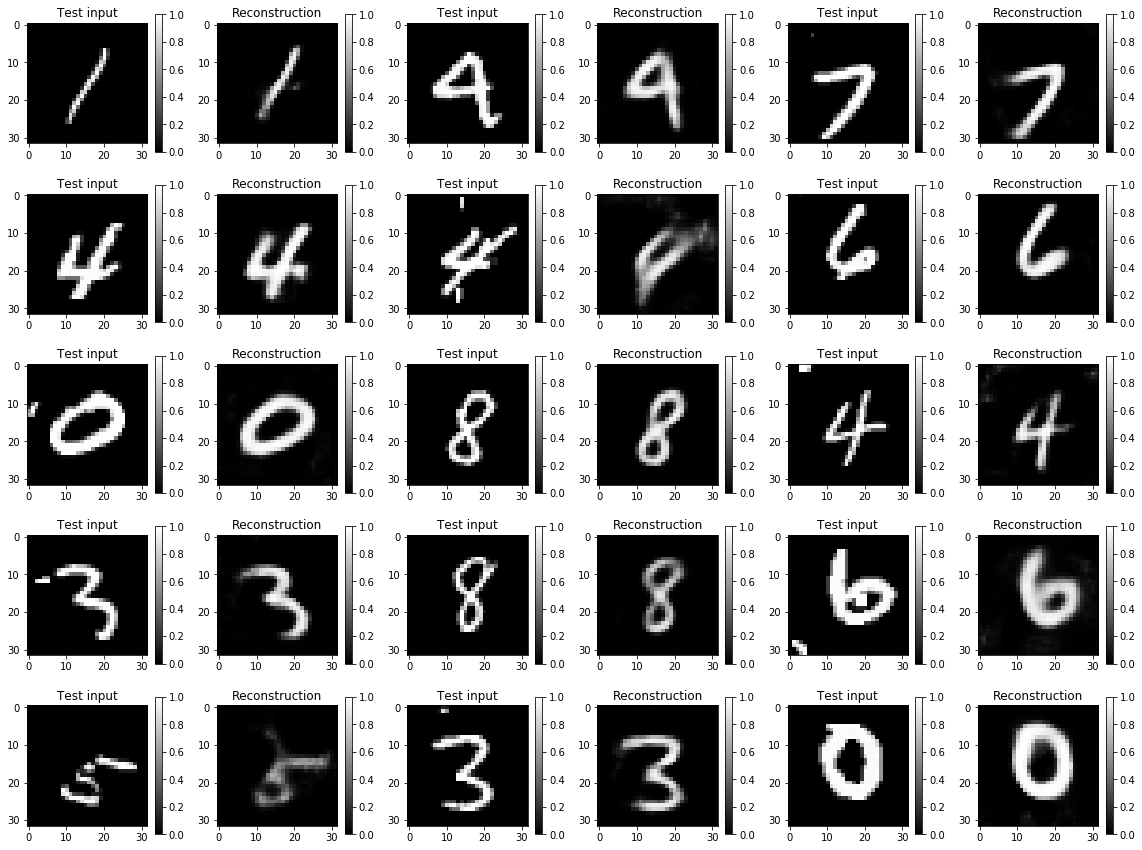

In [6]:
import matplotlib.pyplot as plt

n_width = 32
test_x = mnist.test_32()[:100] / 256
x_reconstruct = vae.reconstruct(test_x.reshape((-1, n_width ** 2)))

plt.figure(figsize=(16, 12))
for i in range(15):
    plt.subplot(5, 6, 2 * i + 1)
    plt.imshow(test_x[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 6, 2 * i + 2)
    plt.imshow(x_reconstruct[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [11]:
vae.sess.close()

In [12]:
del vae

<Figure size 432x288 with 0 Axes>

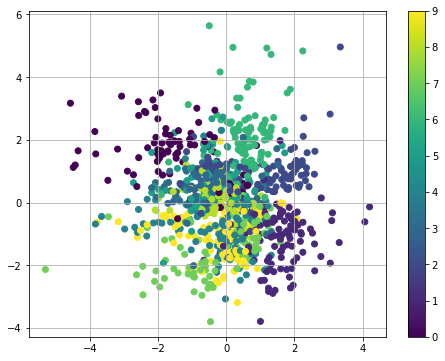

In [4]:
import matplotlib.pyplot as plt

n_width = 32

test_x, test_y = mnist.test()
test_y = test_y[:1000] 
test_x = mnist.test_32()[:1000] / 256
test_x = test_x.reshape((-1, n_width ** 2))
z_mu = vae.transform(test_x)

plt.clf()
plt.figure(figsize=(8, 6))
# print(z_mu[:,0], z_mu[:,1])
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=test_y)
plt.colorbar()
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

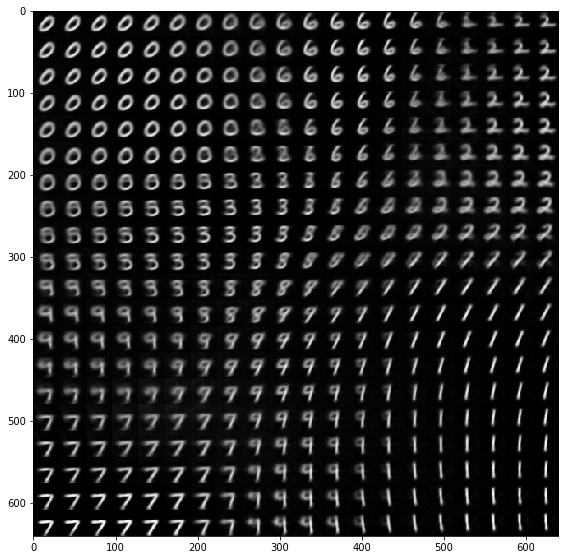

In [6]:
n_width = 32

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((n_width * ny, n_width * nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]] * vae.batch_size)
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*n_width:(nx-i)*n_width, j*n_width:(j+1)*n_width] = x_mean[0].reshape(n_width, n_width)

plt.clf()
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
plt.show()

In [6]:
from sklearn import svm
import mnist

train_x, train_y = mnist.train_32_flat_labeled(10000)
test_x, test_y = mnist.test_32_flat_labeled(300)
train_z = vae.transform(train_x)

clf = svm.SVC()
clf.fit(train_z, train_y)
print(clf.score(vae.transform(test_x), test_y))

0.8766666666666667


In [8]:
from sklearn.neural_network import MLPClassifier

from sklearn import svm
import mnist

train_x, train_y = mnist.train_32_flat_labeled(10000)
test_x, test_y = mnist.test_32_flat_labeled(1000)
train_z = vae.transform(train_x)

clf = MLPClassifier()
clf.fit(train_z, train_y)
print(clf.score(vae.transform(test_x), test_y))

0.899


In [13]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)


class VariationalAutoEncoderOld(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    

def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = VariationalAutoEncoderOld(network_architecture,
                                 learning_rate=learning_rate,
                                 batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_input"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            # print(i)
            batch_xs = train_x[i:i + batch_size].reshape((-1, w))
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
    return vae


network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=32*32, # MNIST data input (img shape: 32*32)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=30)

/home/ubuntu/tensor/lib/python3.5/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 Cost: 224.660873896 Time: 5.767
Epoch: 0002 Cost: 176.007420197 Time: 11.394
Epoch: 0003 Cost: 164.116643016 Time: 17.025
Epoch: 0004 Cost: 158.194471868 Time: 22.650
Epoch: 0005 Cost: 153.707732976 Time: 28.255
Epoch: 0006 Cost: 150.616889623 Time: 33.862
Epoch: 0007 Cost: 148.429655685 Time: 39.479
Epoch: 0008 Cost: 146.917348531 Time: 45.103
Epoch: 0009 Cost: 145.705030645 Time: 50.712
Epoch: 0010 Cost: 144.777639567 Time: 56.323
Epoch: 0011 Cost: 143.853099187 Time: 61.934
Epoch: 0012 Cost: 142.943832092 Time: 67.547
Epoch: 0013 Cost: 142.182579320 Time: 73.186
Epoch: 0014 Cost: 141.416296616 Time: 78.822
Epoch: 0015 Cost: 140.734402059 Time: 84.478
Epoch: 0016 Cost: 140.170605138 Time: 90.134
Epoch: 0017 Cost: 139.654656016 Time: 95.754
Epoch: 0018 Cost: 139.301728592 Time: 101.370
Epoch: 0019 Cost: 138.905718409 Time: 106.983
Epoch: 0020 Cost: 138.533687871 Time: 112.614
Epoch: 0021 Cost: 138.171686630 Time: 118.266
Epoch: 0022 Cost: 137.802608414 Time: 123.874
Epoch:

In [16]:
from sklearn import svm
import mnist

train_x, train_y = mnist.train_32_flat_labeled(20000)
test_x, test_y = mnist.test_32_flat_labeled(1000)
train_z = vae.transform(train_x)

clf = svm.SVC()
clf.fit(train_z, train_y)
print(clf.score(vae.transform(test_x), test_y))

0.927


In [1]:
import numpy as np
import tensorflow as tf
import time

import mnist

tf.logging.set_verbosity(tf.logging.INFO)


class VariationalAutoEncoder(object):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self._initialize_network(**self.network_architecture)
        self.x = tf.placeholder(tf.float32, shape=[None, self.image_width * self.image_width], name="input")

        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.writer = tf.summary.FileWriter(".", self.sess.graph)
        self.sess.run(init)

    def _create_network(self):
        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent space
        self._recognition_network()

        # Draw one sample z from Gaussian distribution
        eps = tf.random_normal((self.batch_size, self.n_z), 0, 1, dtype=tf.float32)
        # z = mu + sigma * epsilon
        self.z = tf.add(self.z_mean, tf.multiply(tf.exp(self.z_log_sigma_sq / 2), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self._generator_network()

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 1)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus
            )
        self.z_mean = tf.layers.dense(
            inputs=self.input_layers[-1],
            units=self.n_z,
            activation=None,
            name="z_mean"
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.input_layers[-1],
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq"
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = self.z
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid)

    def _create_loss_optimizer(self):
        with tf.name_scope("cost"):
            # The loss is composed of two terms:
            # 1.) The reconstruction loss (the negative log probability
            #     of the input under the reconstructed Bernoulli distribution
            #     induced by the decoder in the data space).
            #     This can be interpreted as the number of "nats" required
            #     for reconstructing the input when the activation in latent
            #     is given.
            # Adding 1e-10 to avoid evaluation of log(0.0)
            reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                               + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)

            # 2.) The latent loss, which is defined as the KL divergence
            #     between the distribution in latent space induced by the encoder on
            #     the data and some prior. This acts as a kind of regularizer.
            #     This can be interpreted as the number of "nats" required
            #     for transmitting the the latent space distribution given
            #     the prior.
            latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean)
                                               - tf.exp(self.z_log_sigma_sq), 1)

            self.cost = tf.reduce_mean(reconstr_loss + latent_loss, name="total_cost")  # average over batch
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = VariationalAutoEncoder(network_architecture,
                                 learning_rate=learning_rate,
                                 batch_size=batch_size)
    # Training cycle
    _, train_y = mnist.train()
    train_x = mnist.train_32()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            # print(i)
            batch_xs = np.asarray(train_x[i:i + batch_size], dtype=np.float32) / 256
            batch_xs = batch_xs.reshape((-1, w * w))

            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
    return vae


network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train(network_architecture, training_epochs=30)

Epoch: 0001 Cost: 244.414773356 Time: 5.933
Epoch: 0002 Cost: 208.035695012 Time: 11.764
Epoch: 0003 Cost: 189.529734624 Time: 17.568
Epoch: 0004 Cost: 178.187972819 Time: 23.398
Epoch: 0005 Cost: 171.770263062 Time: 29.205
Epoch: 0006 Cost: 167.854590810 Time: 35.036
Epoch: 0007 Cost: 165.053572795 Time: 40.851
Epoch: 0008 Cost: 162.815124766 Time: 46.682
Epoch: 0009 Cost: 161.012631582 Time: 52.480
Epoch: 0010 Cost: 159.542502950 Time: 58.286
Epoch: 0011 Cost: 158.391260147 Time: 64.097
Epoch: 0012 Cost: 157.442374166 Time: 69.909
Epoch: 0013 Cost: 156.597390518 Time: 75.717
Epoch: 0014 Cost: 156.085693588 Time: 81.566
Epoch: 0015 Cost: 155.497797368 Time: 87.539
Epoch: 0016 Cost: 155.078875529 Time: 93.417


KeyboardInterrupt: 

In [1]:
from vae import VariationalAutoEncoder
network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 1024,
    "n_layers": 2
}

vae = VariationalAutoEncoder(network_architecture,
              learning_rate=0.001,
              batch_size=100)
vae.load("tmp/VariationalAutoEncoder.20180611181831064302.step30")

INFO:tensorflow:Restoring parameters from tmp/VariationalAutoEncoder.20180611181831064302.step30


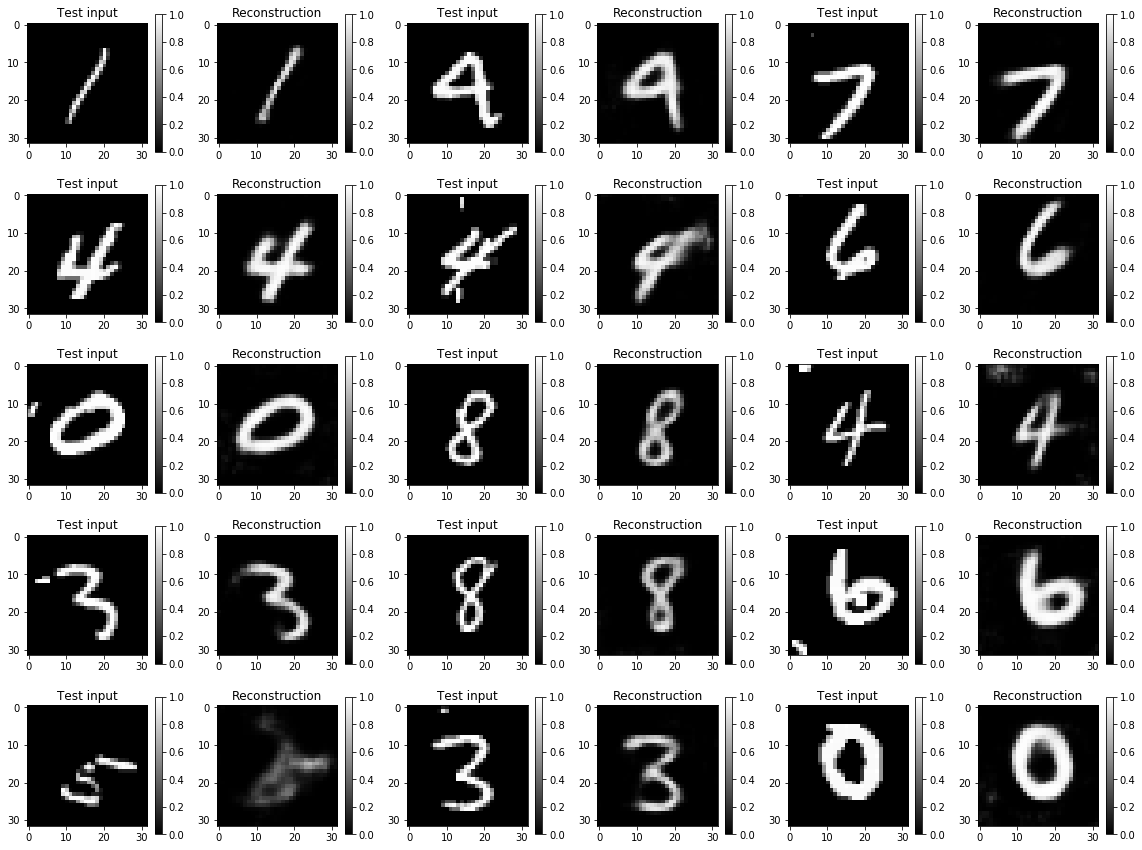

In [3]:
import matplotlib.pyplot as plt
import mnist

n_width = 32
test_x = mnist.test_32()[:100] / 256
x_reconstruct = vae.reconstruct(test_x.reshape((-1, n_width ** 2)))

plt.figure(figsize=(16, 12))
for i in range(15):
    plt.subplot(5, 6, 2 * i + 1)
    plt.imshow(test_x[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 6, 2 * i + 2)
    plt.imshow(x_reconstruct[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [1]:
from vae_cnn import ConvolutionalVariationalAutoEncoder
network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 1024,
    "n_layers": 2
}

vae = ConvolutionalVariationalAutoEncoder(network_architecture,
              learning_rate=0.001,
              batch_size=100)
vae.load("tmp/ConvolutionalVariationalAutoEncoder.20180611183558124624.step20")



INFO:tensorflow:Restoring parameters from tmp/ConvolutionalVariationalAutoEncoder.20180611183558124624.step20


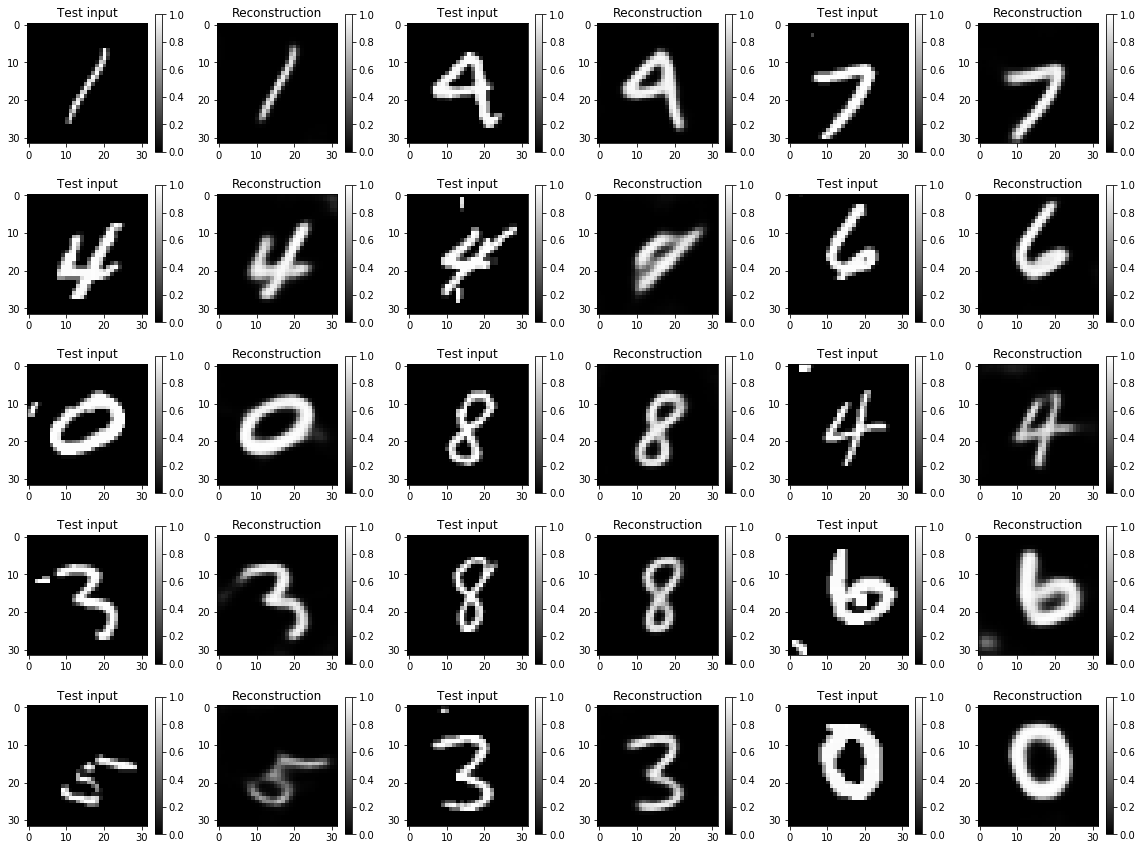

In [3]:
import matplotlib.pyplot as plt
import mnist

n_width = 32
test_x = mnist.test_32()[:100] / 256
x_reconstruct = vae.reconstruct(test_x.reshape((-1, n_width ** 2)))

plt.figure(figsize=(16, 12))
for i in range(15):
    plt.subplot(5, 6, 2 * i + 1)
    plt.imshow(test_x[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 6, 2 * i + 2)
    plt.imshow(x_reconstruct[i].reshape(n_width, n_width), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [7]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import mnist

train_x, train_y = mnist.train_32_flat_labeled()
test_x, test_y = mnist.test_32_flat_labeled()
train_z = vae.transform(train_x)

clf = MLPClassifier()
clf.fit(train_z, train_y)
print(clf.score(vae.transform(test_x), test_y))

0.9439


In [1]:
import numpy as np
import tensorflow as tf

from vae import VariationalAutoEncoder

tf.logging.set_verbosity(tf.logging.INFO)


class CVAE(VariationalAutoEncoder):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.y = tf.placeholder(tf.int64, shape=[None, 1], name="y")
        super().__init__(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 2)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _create_network(self):
        self.input_label = tf.feature_column.input_layer(
            {"label": self.y},
            [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                key='label',
                num_buckets=10))]
        )
        super()._create_network()

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.input_layers[self.n_layers + 1] = tf.layers.dense(
            inputs=self.input_layers[self.n_layers],
            units=25,
            activation=tf.nn.relu,
        )
        self.dense_with_label = tf.concat([self.input_layers[-1], self.input_label], 1)
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_mean",
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq",
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = tf.concat([self.z, self.input_label], 1)
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid,
        )

    def partial_fit_with_y(self, X, y):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X,
                                                                          self.y: y,
                                                                          self.training: True})
        return cost

    def transform_with_y(self, X, y):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y: y, self.training: False})

    def generate_with_y(self, y, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu, self.y: y, self.training: False})

    def reconstruct_with_y(self, X, y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def reconstruct_error(self, X, y):
        return self.sess.run(self.reconstruct_loss,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def predict(self, X):
        med = np.zeros((X.shape[0], 10), dtype=np.float32)
        for clas in range(10):
            guess = np.asarray([clas] * X.shape[0])
            np[:, clas] = self.reconstruct_error(X, guess)
        return np.argmin(med, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y == y_pred) / X.shape([0])


import mnist
import time

def train_cvae(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    vae = CVAE(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))
            batch_ys = train_y[i:i + batch_size]

            cost = vae.partial_fit(batch_xs, batch_ys)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))

    return vae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train_cvae(network_architecture, training_epochs=10)

TypeError: partial_fit() takes 2 positional arguments but 3 were given

In [3]:
import mnist
import time

def train_cvae(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    vae = CVAE(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))
            batch_ys = train_y[i:i + batch_size]

            cost = vae.partial_fit(batch_xs, batch_ys)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))

    return vae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 2
}

vae = train_cvae(network_architecture, training_epochs=10)

ValueError: Variable z_mean/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-1-d212f6be43df>", line 53, in _recognition_network
    name="z_mean",
  File "/home/ubuntu/mnist/vae.py", line 42, in _create_network
    self._recognition_network()
  File "<ipython-input-1-d212f6be43df>", line 30, in _create_network
    super()._create_network()


In [1]:
import numpy as np
import tensorflow as tf

from vae import VariationalAutoEncoder

tf.logging.set_verbosity(tf.logging.INFO)


class CVAE(VariationalAutoEncoder):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.y = tf.placeholder(tf.int64, shape=(None,), name="y")
        super().__init__(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 2)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _create_network(self):
        with tf.name_scope("labels"):
            self.input_label = tf.feature_column.input_layer(
                {"label": self.y},
                [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                    key='label',
                    num_buckets=10))]
            )
        super()._create_network()

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.input_layers[self.n_layers + 1] = tf.layers.dense(
            inputs=self.input_layers[self.n_layers],
            units=25,
            activation=tf.nn.relu,
        )
        self.dense_with_label = tf.concat([self.input_layers[self.n_layers], self.input_label], 1)
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_mean",
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq",
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = tf.concat([self.z, self.input_label], 1)
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid,
        )

    def partial_fit_with_y(self, X, y):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X,
                                                                          self.y: y,
                                                                          self.training: True})
        return cost

    def transform_with_y(self, X, y):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y: y, self.training: False})

    def generate_with_y(self, y, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu, self.y: y, self.training: False})

    def reconstruct_with_y(self, X, y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def reconstruct_error(self, X, y):
        return self.sess.run(self.reconstruct_loss,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def predict(self, X):
        med = np.zeros((X.shape[0], 10), dtype=np.float32)
        for clas in range(10):
            guess = np.asarray([clas] * X.shape[0])
            med[:, clas] = self.reconstruct_error(X, guess)
        return np.argmin(med, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y == y_pred) / X.shape[0]


import mnist
import time

def train_cvae(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    vae = CVAE(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))
            batch_ys = train_y[i:i + batch_size]

            cost = vae.partial_fit_with_y(batch_xs, batch_ys)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))

        if epoch % 

    return vae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3
}

vae = train_cvae(network_architecture, training_epochs=10)

Epoch: 0001 Cost: 230.806110814 Time: 7.789
Epoch: 0002 Cost: 182.901653748 Time: 15.479
Epoch: 0003 Cost: 167.317793376 Time: 23.208
Epoch: 0004 Cost: 160.086056290 Time: 30.960
Epoch: 0005 Cost: 156.356125310 Time: 38.678
Epoch: 0006 Cost: 153.916974818 Time: 46.369
Epoch: 0007 Cost: 152.137159678 Time: 54.087
Epoch: 0008 Cost: 150.408357264 Time: 61.802
Epoch: 0009 Cost: 148.688297195 Time: 69.509
Epoch: 0010 Cost: 147.173759715 Time: 77.255
[8 8 1 7 6 1 8 3 7 3 8 0 8 2 3 4 1 3 8 5 9 3 6 4 9 9 8 0 2 3 6 7 0 7 1 0 3
 7 1 4 5 8 9 6 7 9 2 5 1 2 3 9 9 4 6 4 6 3 3 2 7 2 5 0 4 9 7 4 8 9 6 1 6 0
 9 8 5 7 0 3 3 3 6 3 7 1 5 6 1 7 5 4 7 7 5 7 8 2 4 8]
[8 8 1 7 6 1 8 3 7 3 8 0 8 2 3 4 1 3 8 5 9 3 6 4 9 9 8 0 2 3 6 7 0 7 1 6 3
 7 2 4 5 8 9 6 4 9 2 3 1 2 3 9 9 4 6 4 6 3 3 2 7 2 5 0 4 9 7 9 8 9 6 1 6 0
 9 6 5 7 0 3 3 3 6 3 7 1 5 6 1 7 5 4 7 7 5 7 8 0 4 8]


In [4]:
test_x, test_y = mnist.test_32_flat_labeled(10000)

vae.score(test_x, test_y)

0.8771

In [1]:
import numpy as np
import tensorflow as tf

from vae import VariationalAutoEncoder

tf.logging.set_verbosity(tf.logging.INFO)


class CVAE(VariationalAutoEncoder):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.y = tf.placeholder(tf.int64, shape=(None,), name="y")
        super().__init__(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 2)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _create_network(self):
        with tf.name_scope("labels"):
            self.input_label = tf.feature_column.input_layer(
                {"label": self.y},
                [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                    key='label',
                    num_buckets=10))]
            )
        super()._create_network()

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.input_layers[self.n_layers + 1] = tf.layers.dense(
            inputs=self.input_layers[self.n_layers],
            units=25,
            activation=tf.nn.relu,
        )
        self.dense_with_label = tf.concat([self.input_layers[self.n_layers], self.input_label], 1)
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_mean",
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq",
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = tf.concat([self.z, self.input_label], 1)
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid,
        )

    def partial_fit_with_y(self, X, y):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X,
                                                                          self.y: y,
                                                                          self.training: True})
        return cost

    def transform_with_y(self, X, y):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y: y, self.training: False})

    def generate_with_y(self, y, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu, self.y: y, self.training: False})

    def reconstruct_with_y(self, X, y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def reconstruct_error(self, X, y):
        return self.sess.run(self.reconstruct_loss,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def predict(self, X):
        med = np.zeros((X.shape[0], 10), dtype=np.float32)
        for clas in range(10):
            guess = np.asarray([clas] * X.shape[0])
            med[:, clas] = self.reconstruct_error(X, guess)
        return np.argmin(med, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y == y_pred) / X.shape[0]


import mnist
import time

def train_cvae(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    vae = CVAE(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))
            batch_ys = train_y[i:i + batch_size]

            cost = vae.partial_fit_with_y(batch_xs, batch_ys)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
        if epoch % saving_step == 0:
            test_x, test_y = mnist.test_32_flat_labeled()
            print("Accuracy:", vae.score(test_x, test_y))

    return vae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3,
}

vae = train_cvae(network_architecture, training_epochs=300)

Epoch: 0001 Cost: 229.170336482 Time: 7.801
Accuracy: 0.4301
Epoch: 0002 Cost: 183.550464884 Time: 18.023
Epoch: 0003 Cost: 166.507932561 Time: 25.708
Epoch: 0004 Cost: 159.660830154 Time: 33.476
Epoch: 0005 Cost: 156.121136500 Time: 41.159
Epoch: 0006 Cost: 153.736357142 Time: 48.886
Epoch: 0007 Cost: 151.641120656 Time: 56.566
Epoch: 0008 Cost: 149.776666183 Time: 64.251
Epoch: 0009 Cost: 148.019893595 Time: 71.935
Epoch: 0010 Cost: 146.679087499 Time: 79.643
Epoch: 0011 Cost: 145.562960332 Time: 87.313
Accuracy: 0.8873
Epoch: 0012 Cost: 144.611634674 Time: 97.408
Epoch: 0013 Cost: 143.886328837 Time: 105.092
Epoch: 0014 Cost: 143.142822723 Time: 112.765
Epoch: 0015 Cost: 142.539470215 Time: 120.435
Epoch: 0016 Cost: 141.931910070 Time: 128.131
Epoch: 0017 Cost: 141.350482152 Time: 135.821
Epoch: 0018 Cost: 140.879091619 Time: 143.490
Epoch: 0019 Cost: 140.508603732 Time: 151.200
Epoch: 0020 Cost: 140.164232877 Time: 158.926
Epoch: 0021 Cost: 139.776100171 Time: 166.590
Accuracy: 0.9

Epoch: 0173 Cost: nan Time: 1380.774
Epoch: 0174 Cost: nan Time: 1388.482
Epoch: 0175 Cost: nan Time: 1396.225


KeyboardInterrupt: 

In [1]:
import numpy as np
import tensorflow as tf

from vae import VariationalAutoEncoder

tf.logging.set_verbosity(tf.logging.INFO)


class CVAE(VariationalAutoEncoder):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.y = tf.placeholder(tf.int64, shape=(None,), name="y")
        super().__init__(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 2)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _create_network(self):
        with tf.name_scope("labels"):
            self.input_label = tf.feature_column.input_layer(
                {"label": self.y},
                [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                    key='label',
                    num_buckets=10))]
            )
        super()._create_network()

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.input_layers[self.n_layers + 1] = tf.layers.dense(
            inputs=self.input_layers[self.n_layers],
            units=10,
            activation=tf.nn.tanh,
        )
        self.dense_with_label = tf.concat([self.input_layers[self.n_layers], self.input_label], 1)
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_mean",
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq",
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = tf.concat([self.z, self.input_label], 1)
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid,
        )

    def partial_fit_with_y(self, X, y):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X,
                                                                          self.y: y,
                                                                          self.training: True})
        return cost

    def transform_with_y(self, X, y):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y: y, self.training: False})

    def generate_with_y(self, y, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu, self.y: y, self.training: False})

    def reconstruct_with_y(self, X, y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def reconstruct_error(self, X, y):
        return self.sess.run(self.reconstruct_loss,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def predict(self, X):
        med = np.zeros((X.shape[0], 10), dtype=np.float32)
        for clas in range(10):
            guess = np.asarray([clas] * X.shape[0])
            med[:, clas] = self.reconstruct_error(X, guess)
        return np.argmin(med, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y == y_pred) / X.shape[0]


import mnist
import time

def train_cvae(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    vae = CVAE(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))
            batch_ys = train_y[i:i + batch_size]

            cost = vae.partial_fit_with_y(batch_xs, batch_ys)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
        if epoch % saving_step == 0:
            test_x, test_y = mnist.test_32_flat_labeled()
            print("Accuracy:", vae.score(test_x, test_y))

    return vae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3,
}

vae = train_cvae(network_architecture, training_epochs=50)

Epoch: 0001 Cost: 229.486730754 Time: 7.809
Accuracy: 0.3937
Epoch: 0002 Cost: 183.135545603 Time: 17.914
Epoch: 0003 Cost: 166.885085678 Time: 25.667
Epoch: 0004 Cost: 159.874485067 Time: 33.402
Epoch: 0005 Cost: 156.266702652 Time: 41.100
Epoch: 0006 Cost: 153.947642161 Time: 48.757
Epoch: 0007 Cost: 152.166186371 Time: 56.472
Epoch: 0008 Cost: 150.721160355 Time: 64.146


KeyboardInterrupt: 

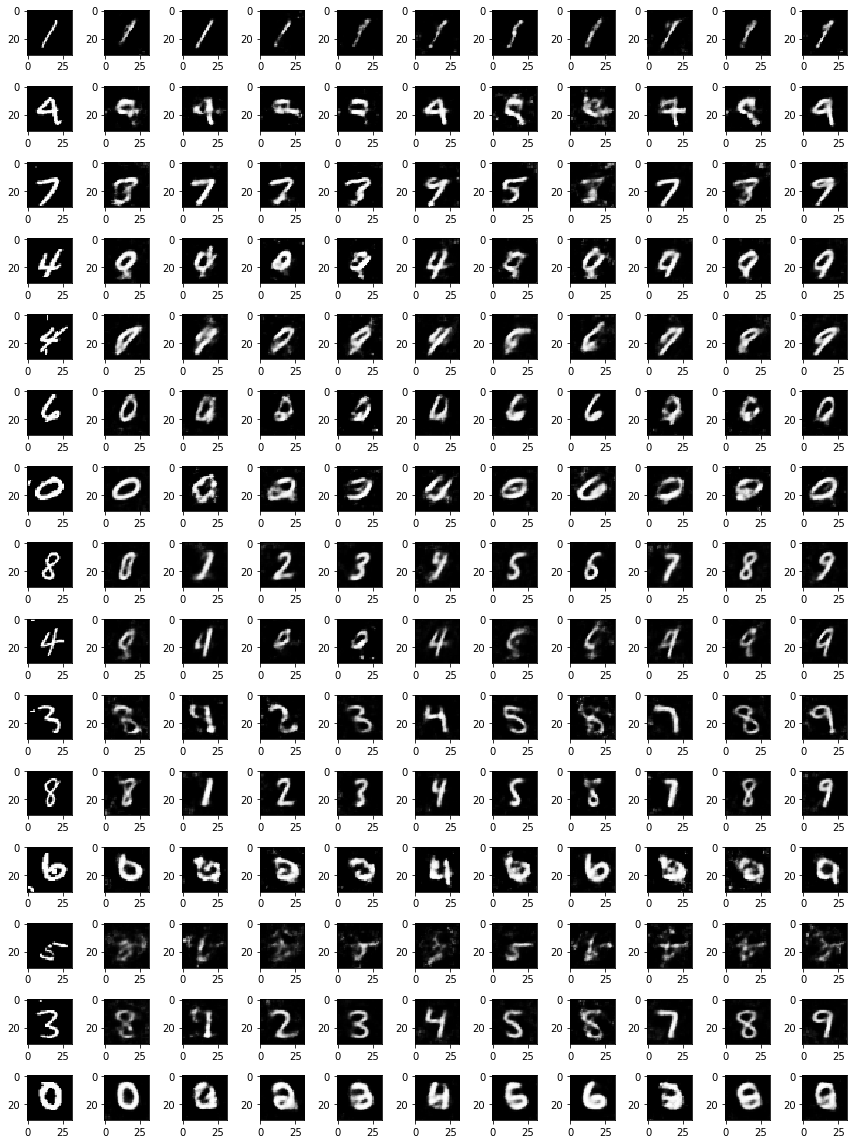

In [7]:
import matplotlib.pyplot as plt
import mnist

n_width = 32
test_x, test_y = mnist.test_32_flat_labeled(15)

x_reconstruct = vae.reconstruct_with_y(test_x, test_y)
pred_y = vae.predict(test_x)

plt.figure(figsize=(12, 16))
for i in range(15):
    plt.subplot(15, 11, 11 * i + 1)
    plt.imshow(test_x[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.title("%d / %d" % (test_y[i], pred_y[i]))
    plt.axis("off")
for clas in range(10):
    guess = np.asarray([clas] * test_x.shape[0])
    med = vae.reconstruct_with_y(test_x, guess)
    for i in range(15):
        plt.subplot(15, 11, 11 * i + clas + 2)
        plt.imshow(med[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import tensorflow as tf

from vae import VariationalAutoEncoder

tf.logging.set_verbosity(tf.logging.INFO)


class CVAE(VariationalAutoEncoder):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.y = tf.placeholder(tf.int64, shape=(None,), name="y")
        super().__init__(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_layers = [None for i in range(self.n_layers + 2)]
        self.output_layers = [None for i in range(self.n_layers + 1)]

    def _create_network(self):
        with tf.name_scope("labels"):
            self.input_label = tf.feature_column.input_layer(
                {"label": self.y},
                [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                    key='label',
                    num_buckets=10))]
            )
        super()._create_network()

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_layers[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=self.input_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.input_layers[self.n_layers + 1] = tf.layers.dense(
            inputs=self.input_layers[self.n_layers],
            units=25,
            activation=tf.nn.relu,
        )
        self.dense_with_label = tf.concat([self.input_layers[self.n_layers], self.input_label], 1)
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_mean",
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq",
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_layers[0] = tf.concat([self.z, self.input_label], 1)
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=self.output_layers[i - 1],
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_layers[-1],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid,
        )

    def partial_fit_with_y(self, X, y):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X,
                                                                          self.y: y,
                                                                          self.training: True})
        return cost

    def transform_with_y(self, X, y):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y: y, self.training: False})

    def generate_with_y(self, y, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu, self.y: y, self.training: False})

    def reconstruct_with_y(self, X, y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def reconstruct_error(self, X, y):
        return self.sess.run(self.cost,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def predict(self, X):
        med = np.zeros((X.shape[0], 10), dtype=np.float32)
        for clas in range(10):
            guess = np.asarray([clas] * X.shape[0])
            med[:, clas] = self.reconstruct_error(X, guess)
        return np.argmin(med, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y == y_pred) / X.shape[0]


import mnist
import time

def train_cvae(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    vae = CVAE(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))
            batch_ys = train_y[i:i + batch_size]

            cost = vae.partial_fit_with_y(batch_xs, batch_ys)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
        if epoch % saving_step == 0:
            test_x, test_y = mnist.test_32_flat_labeled()
            print("Accuracy:", vae.score(test_x, test_y))

    return vae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3,
}

vae = train_cvae(network_architecture, training_epochs=300)

Epoch: 0001 Cost: 230.819859924 Time: 7.856
Accuracy: 0.1193
Epoch: 0002 Cost: 185.553427836 Time: 18.025
Epoch: 0003 Cost: 169.130468572 Time: 25.706
Epoch: 0004 Cost: 161.022030258 Time: 33.452
Epoch: 0005 Cost: 156.544503479 Time: 41.180
Epoch: 0006 Cost: 153.177079824 Time: 48.890
Epoch: 0007 Cost: 150.536573690 Time: 56.616
Epoch: 0008 Cost: 148.590916367 Time: 64.363
Epoch: 0009 Cost: 147.178656718 Time: 72.184
Epoch: 0010 Cost: 145.992028809 Time: 79.913
Epoch: 0011 Cost: 145.061529261 Time: 87.614
Accuracy: 0.0962
Epoch: 0012 Cost: 144.201445033 Time: 97.769


KeyboardInterrupt: 

In [1]:
import numpy as np
import tensorflow as tf

from vae import VariationalAutoEncoder

tf.logging.set_verbosity(tf.logging.INFO)


class CVAE(VariationalAutoEncoder):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        self.y = tf.placeholder(tf.int64, shape=(None,), name="y")
        super().__init__(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

    def _initialize_network(self, n_z, n_width, n_hidden_units, n_layers, **kwargs):
        self.n_z = n_z
        self.image_width = n_width
        self.n_hidden_units = n_hidden_units
        self.n_layers = n_layers
        self.input_dropout = [None for i in range(self.n_layers + 2)]
        self.output_dropout = [None for i in range(self.n_layers + 2)]
        self.input_layers = [None for i in range(self.n_layers + 2)]
        self.output_layers = [None for i in range(self.n_layers + 2)]

    def _create_network(self):
        with tf.name_scope("labels"):
            self.input_label = tf.feature_column.input_layer(
                {"label": self.y},
                [tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_identity(
                    key='label',
                    num_buckets=10))]
            )
        super()._create_network()

    def _recognition_network(self):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        self.input_dropout[0] = tf.layers.flatten(self.x)
        for i in range(1, self.n_layers + 1):
            self.input_layers[i] = tf.layers.dense(
                inputs=tf.concat([self.input_dropout[i - 1], self.input_label], 1),
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
            self.input_dropout[i] = tf.layers.dropout(
                inputs=self.input_layers[i],
                rate=0.1,
                training=self.training,
            )
        self.dense_with_label = tf.concat([self.input_dropout[self.n_layers], self.input_label], 1)
        self.z_mean = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_mean",
        )
        self.z_log_sigma_sq = tf.layers.dense(
            inputs=self.dense_with_label,
            units=self.n_z,
            activation=None,
            name="z_log_sigma_sq",
        )

    def _generator_network(self):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        self.output_dropout[0] = tf.concat([self.z, self.input_label], 1)
        for i in range(1, self.n_layers + 1):
            self.output_layers[i] = tf.layers.dense(
                inputs=tf.concat([self.output_dropout[i - 1], self.input_label], 1),
                units=self.n_hidden_units,
                activation=tf.nn.softplus,
            )
            self.output_dropout[i] = tf.layers.dropout(
                inputs=self.output_layers[i],
                rate=0.1,
                training=self.training,
            )
        self.x_reconstr_mean = tf.layers.dense(
            inputs=self.output_dropout[self.n_layers],
            units=self.image_width * self.image_width,
            activation=tf.nn.sigmoid,
        )

    def partial_fit_with_y(self, X, y):
        """
        Train model based on mini-batch of input data.
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X,
                                                                          self.y: y,
                                                                          self.training: True})
        return cost

    def transform_with_y(self, X, y):
        """
        Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.y: y, self.training: False})

    def generate_with_y(self, y, z_mu=None):
        """
        Generate data by sampling from latent space.
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu, self.y: y, self.training: False})

    def reconstruct_with_y(self, X, y):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def reconstruct_error(self, X, y):
        return self.sess.run(self.reconstruct_loss,
                             feed_dict={self.x: X, self.y: y, self.training: False})

    def predict(self, X):
        med = np.zeros((X.shape[0], 10), dtype=np.float32)
        for clas in range(10):
            guess = np.asarray([clas] * X.shape[0])
            med[:, clas] = self.reconstruct_error(X, guess)
        return np.argmin(med, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y == y_pred) / X.shape[0]


import mnist
import time

def train_cvae(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1, saving_step=10):
    vae = CVAE(network_architecture,
              learning_rate=learning_rate,
              batch_size=batch_size)
    # Training cycle
    train_x, train_y = mnist.train_32_flat_labeled()
    n_samples = train_x.shape[0]
    w = network_architecture["n_width"]

    t0 = time.time()
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in range(0, n_samples, batch_size):
            batch_xs = train_x[i:i + batch_size].reshape((-1, w * w))
            batch_xs = batch_xs.reshape((-1, w * w))
            batch_ys = train_y[i:i + batch_size]

            cost = vae.partial_fit_with_y(batch_xs, batch_ys)
            avg_cost += cost / n_samples * batch_size
        t1 = time.time()

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "Cost:", "{:.9f}".format(avg_cost),
                  "Time:", "%.3f" % (t1 - t0))
        if epoch % saving_step == 0:
            test_x, test_y = mnist.test_32_flat_labeled()
            print("Accuracy:", vae.score(test_x, test_y))

    return vae

network_architecture = {
    "n_width": 32,
    "n_z": 20,  # dimensionality of latent space
    "n_hidden_units": 500,
    "n_layers": 3,
}
vae = CVAE(network_architecture,
           learning_rate=0.001,
           batch_size=100)
vae.load("tmp/CVAE.20180612074609542397.step50")


INFO:tensorflow:Restoring parameters from tmp/CVAE.20180612074609542397.step50


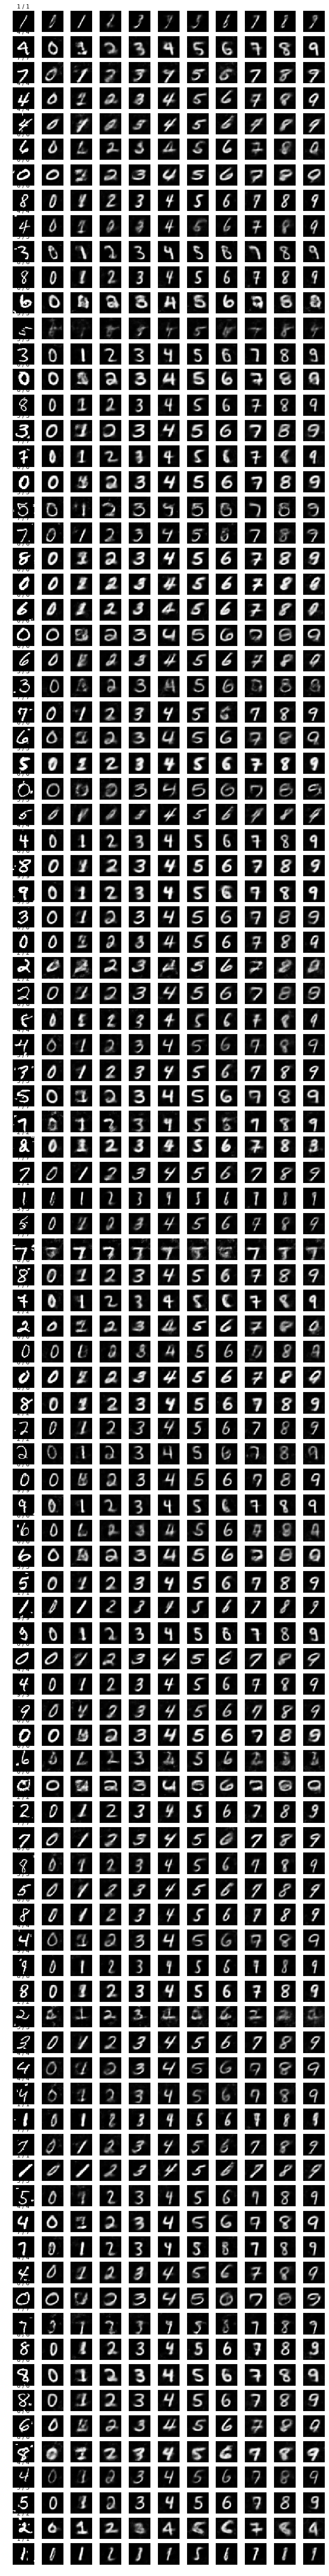

In [7]:
import matplotlib.pyplot as plt
import mnist

n_width = 32
n_samples = 100
test_x, test_y = mnist.test_32_flat_labeled(n_samples)

x_reconstruct = vae.reconstruct_with_y(test_x, test_y)
pred_y = vae.predict(test_x)

plt.figure(figsize=(12, n_samples))
for i in range(n_samples):
    plt.subplot(n_samples, 12, 12 * i + 1)
    plt.text(0, 0, "%d / %d" % (test_y[i], pred_y[i]))
    plt.subplot(n_samples, 12, 12 * i + 2)
    plt.imshow(test_x[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
for clas in range(10):
    guess = np.asarray([clas] * test_x.shape[0])
    med = vae.reconstruct_with_y(test_x, guess)
    for i in range(n_samples):
        plt.subplot(n_samples, 12, 12 * i + clas + 2)
        plt.imshow(med[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
# plt.tight_layout()
plt.savefig("test.png")

/home/ubuntu/tensor/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


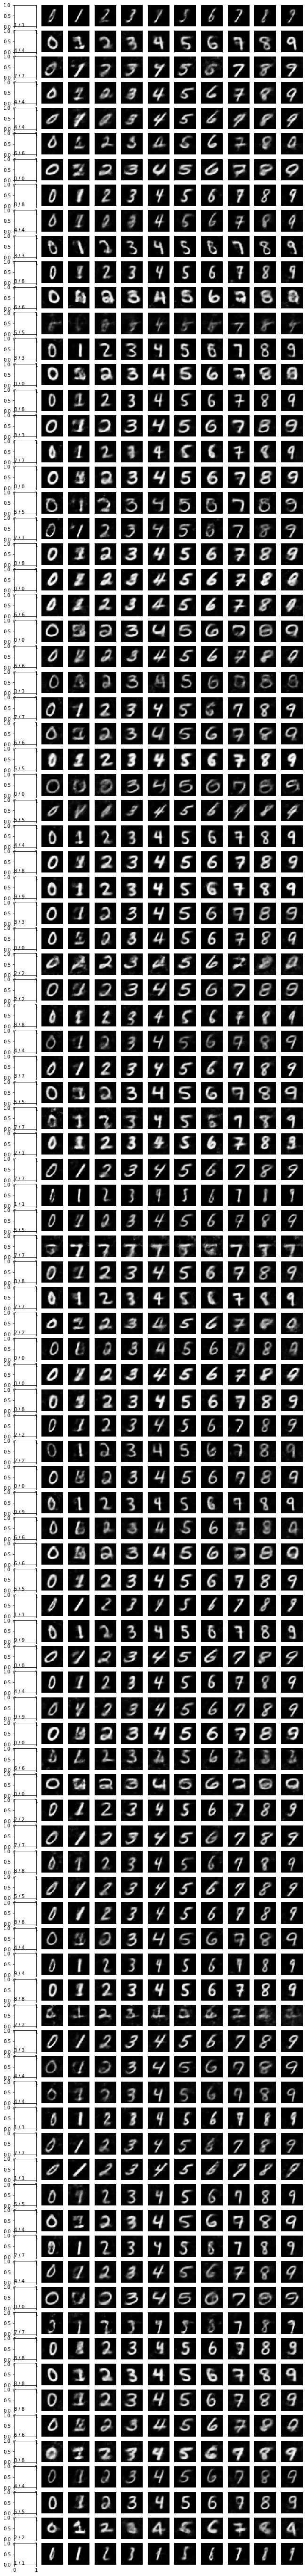

In [8]:
import matplotlib.pyplot as plt
import mnist

n_width = 32
n_samples = 100
test_x, test_y = mnist.test_32_flat_labeled(n_samples)

x_reconstruct = vae.reconstruct_with_y(test_x, test_y)
pred_y = vae.predict(test_x)

plt.figure(figsize=(12, n_samples))
for i in range(n_samples):
    plt.subplot(n_samples, 12, 12 * i + 1)
    plt.text(0, 0, "%d / %d" % (test_y[i], pred_y[i]))
    plt.axis("off")
    plt.subplot(n_samples, 12, 12 * i + 2)
    plt.imshow(test_x[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
for clas in range(10):
    guess = np.asarray([clas] * test_x.shape[0])
    med = vae.reconstruct_with_y(test_x, guess)
    for i in range(n_samples):
        plt.subplot(n_samples, 12, 12 * i + clas + 3)
        plt.imshow(med[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
# plt.tight_layout()
plt.savefig("test.png")

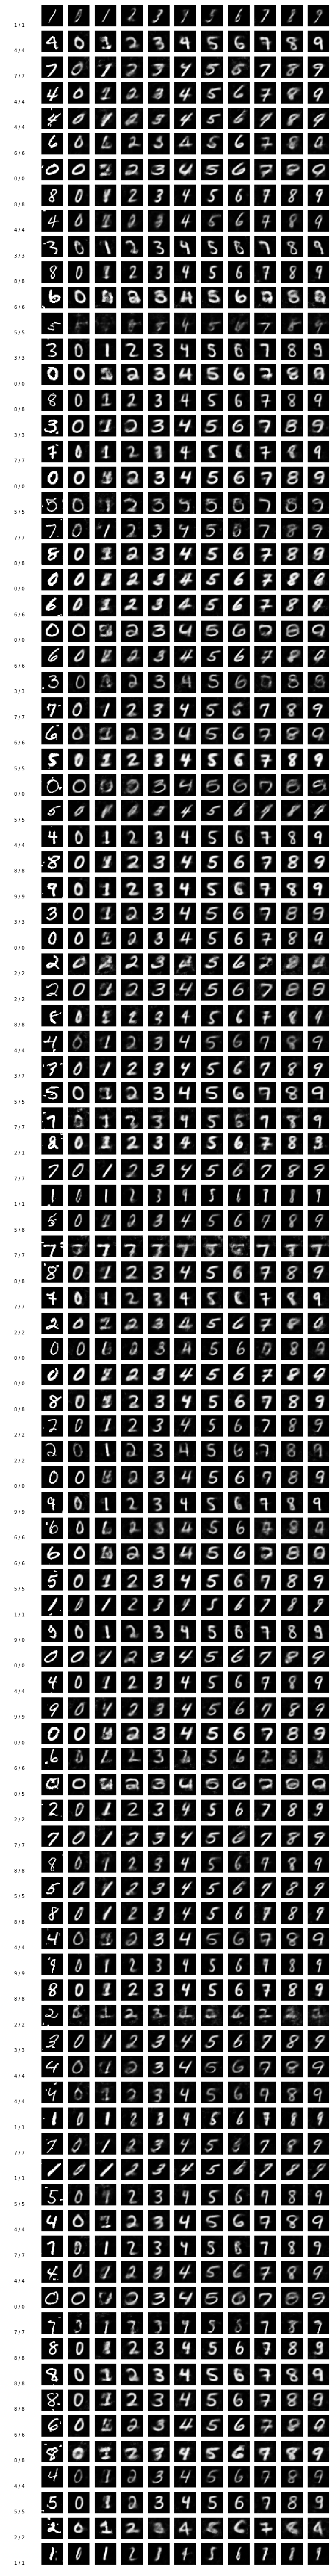

In [10]:
import matplotlib.pyplot as plt
import mnist
import numpy as np

n_width = 32
n_samples = 0
test_x, test_y = mnist.test_32_flat_labeled(1000)

x_reconstruct = vae.reconstruct_with_y(test_x, test_y)
pred_y = vae.predict(test_x)
x, py, y = [], [], []

idx = list(filter(lambda x: test_y[i] != pred_y[i], range(1000)))
x = np.asarray([test_x[i] for i in idx])
py = np.asarray([pred_y[i] for i in idx])
y = np.asarray([test_y[i] for i in idx])
print(py)
print(y)

plt.figure(figsize=(12, n_samples))
for i in range(n_samples):
    plt.subplot(n_samples, 12, 12 * i + 1)
    plt.text(0, 0, "%d / %d" % (y[i], py[i]))
    plt.axis("off")
    plt.subplot(n_samples, 12, 12 * i + 2)
    plt.imshow(x[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
for clas in range(10):
    guess = np.asarray([clas] * x.shape[0])
    med = vae.reconstruct_with_y(x, guess)
    for i in range(n_samples):
        plt.subplot(n_samples, 12, 12 * i + clas + 3)
        plt.imshow(med[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
# plt.tight_layout()
plt.savefig("test.png")

[7 1 6 0 5 5 7 8 4 3 7 7 5 3 5 2 9 3 7 3 5 7 3 8 3 9 6 3 0 6 7 4 8 9 7 4 8
 0 1 9 1 2 9 1 4 7 7 9 6 8 2 4 1 9 8]
[3 2 5 9 0 8 9 9 7 5 9 4 3 0 8 3 4 5 1 4 8 9 8 9 5 7 7 5 6 5 9 9 1 8 1 9 3
 3 3 8 7 7 4 5 9 9 1 6 5 9 7 7 2 7 3]


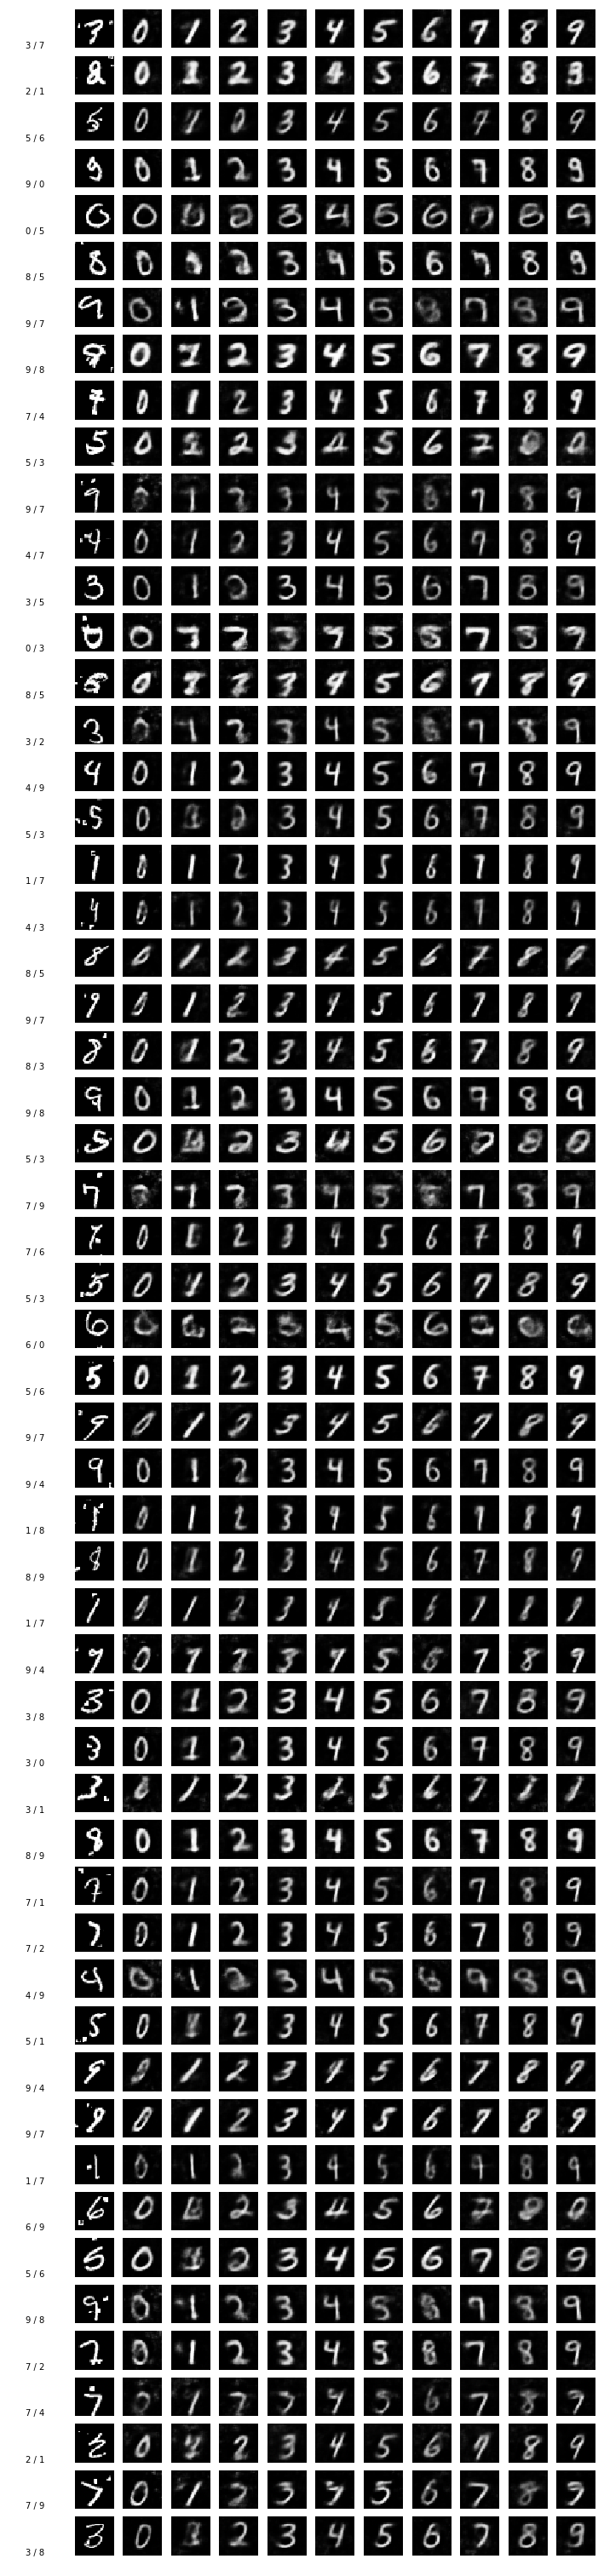

In [13]:
import matplotlib.pyplot as plt
import mnist
import numpy as np

n_width = 32
n_samples = 0
test_x, test_y = mnist.test_32_flat_labeled(1000)

x_reconstruct = vae.reconstruct_with_y(test_x, test_y)
pred_y = vae.predict(test_x)
x, py, y = [], [], []

idx = list(filter(lambda i: test_y[i] != pred_y[i], range(1000)))
x = np.asarray([test_x[i] for i in idx])
py = np.asarray([pred_y[i] for i in idx])
y = np.asarray([test_y[i] for i in idx])
print(py)
print(y)
n_samples = len(y)

plt.figure(figsize=(12, n_samples))
for i in range(n_samples):
    plt.subplot(n_samples, 12, 12 * i + 1)
    plt.text(0, 0, "%d / %d" % (y[i], py[i]))
    plt.axis("off")
    plt.subplot(n_samples, 12, 12 * i + 2)
    plt.imshow(x[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
for clas in range(10):
    guess = np.asarray([clas] * x.shape[0])
    med = vae.reconstruct_with_y(x, guess)
    for i in range(n_samples):
        plt.subplot(n_samples, 12, 12 * i + clas + 3)
        plt.imshow(med[i].reshape(32, 32), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
# plt.tight_layout()
plt.savefig("test.png")